In [1]:
#######################################
########## IMPORTS ####################
from localLibrary_AWSConnector import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime 


from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score



In [2]:
#HELPER FUNCTIONS

#Returns dictionary of dataframes
def get_data():
    data_list = []
    data_dict = {}
    
    file_dir = os.getcwd() + '\\data\\'
    items = os.listdir(file_dir)
    
    for i in items:
        if i == 'SG_STM_purchase_date.csv':
            pass
        else:
            file = i.replace('.csv', '')
            data_list.append(file)

            # Save STM files as DataFrames
            data_dict[file] = pd.read_csv(file_dir + i, index_col=0)

    print(data_list)
    
    return data_dict

#Convert time helper
def _convert_time_to_int(time):
    #print(time)
    if time != time:
        return 0
    elif time == 0:
        return 0
    else:
        return int(''.join(c for c in time if c.isdigit()))

#convert date columns to int  for given df   
def convert_time_int(df):
    
    df['EarliestCRM_int'] = [_convert_time_to_int(x) for x in df['EarliestCRM']]
    df['LatestCRM_int'] = [_convert_time_to_int(x) for x in df['LatestCRM']]

    df['LatestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['LatestSeatGeekDate']]
    df['EarliestSeatGeek_int'] = [_convert_time_to_int(x) for x in df['EarliestSeatGeekDate']]

    df['EarliestMarketo_int'] = [_convert_time_to_int(x) for x in df['EarliestMarketoDate']]
    df['LatestMarketo_int'] = [_convert_time_to_int(x) for x in df['LatestMarketoDate']]

    df['EarliestFanatics_int'] = [_convert_time_to_int(x) for x in df['EarliestFanaticsDate']]
    df['LatestFanatics_int'] = [_convert_time_to_int(x) for x in df['LatestFanaticsDate']]

    df['EarliestYinzcam_int'] = [_convert_time_to_int(x) for x in df['EarliestYinzcamDate']]
    df['LatestYinzcam_int'] = [_convert_time_to_int(x) for x in df['LatestYinzcamDate']]
    
    df['Purchase Date'] = [_convert_time_to_int(x) for x in df['Purchase Date']]
    
    return df

#Creates date difference column (latest - earliest)
def calculate_time_diff(df):
    
    df['CRM_diff'] = df['LatestCRM_int'] - df['EarliestCRM_int']
    df['SeatGeek_diff'] = df['LatestSeatGeek_int'] - df['EarliestSeatGeek_int']
    df['Marketo_diff'] = df['LatestMarketo_int'] - df['EarliestMarketo_int']
    df['Fanatics_diff'] = df['LatestFanatics_int'] - df['EarliestFanatics_int']
    df['Yinzcam_diff'] = df['LatestYinzcam_int'] - df['EarliestYinzcam_int']
    
    df['CRM_to_purchase'] = df['Purchase Date'] - df['LatestCRM_int']
    df['SeatGeek_to_purchase'] = df['Purchase Date'] - df['LatestSeatGeek_int']
    df['Marketo_to_purchase'] = df['Purchase Date'] - df['LatestMarketo_int']
    df['Fanatics_to_purchase'] = df['Purchase Date'] - df['LatestFanatics_int']
    df['Yinzcam_to_purchase'] = df['Purchase Date'] - df['LatestYinzcam_int']
    
    return df

In [3]:
all_data = get_data()

['CRM_lost', 'CRM_nonSTM', 'CRM_STM', 'FTS_lost', 'FTS_nonSTM', 'FTS_STM', 'MK_lost', 'MK_nonSTM', 'MK_STM', 'SG_lost', 'SG_nonSTM', 'SG_STM', 'YZ_lost', 'YZ_nonSTM', 'YZ_STM']


In [4]:
archived_data = all_data.copy()

In [5]:

for key in all_data.keys():
    #SEATGEEK PIVOT
    if 'SG' in key:
        pivoted = pd.pivot_table(all_data[key], 
                         values=['TotalSeatGeekTransactions','TotalTicketVolume','TotalScannedTicketVolume','TotalTicketDollarValue'], 
                         index=['SSB_CRMSYSTEM_CONTACT_ID'],
                         columns=['cjsgActivityType', 'cjsgSecondaryTicketType'], 
                         aggfunc=(np.sum), 
                         fill_value=0)
        #pivoted.columns = [' '.join(col).strip() for col in pivoted.columns.values]
        pivoted = pd.DataFrame(pivoted.to_records())

        pivoted_agg = pd.DataFrame()
        pivoted_agg['SSB_CRMSYSTEM_CONTACT_ID'] = pivoted['SSB_CRMSYSTEM_CONTACT_ID']
        pivoted_agg['total_scanned'] = pivoted["('TotalScannedTicketVolume', 'Purchase', 'Primary')"] + pivoted["('TotalScannedTicketVolume', 'Purchase', 'Resale')"] + pivoted["('TotalScannedTicketVolume', 'Purchase', 'Transfer')"]

        pivoted_agg['primary_purchase_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Resale')"] + pivoted["('TotalSeatGeekTransactions', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_transactions'] = pivoted["('TotalSeatGeekTransactions', 'Sell', 'Resale')"] + pivoted["('TotalSeatGeekTransactions', 'Sell', 'Transfer')"]

        pivoted_agg['primary_purchase_dollars'] = pivoted["('TotalTicketDollarValue', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_dollars'] = pivoted["('TotalTicketDollarValue', 'Purchase', 'Resale')"] + pivoted["('TotalTicketDollarValue', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_dollars'] = pivoted["('TotalTicketDollarValue', 'Sell', 'Resale')"] + pivoted["('TotalTicketDollarValue', 'Sell', 'Transfer')"]

        pivoted_agg['primary_purchase_tickets'] = pivoted["('TotalTicketVolume', 'Purchase', 'Primary')"]
        pivoted_agg['secondary_purchase_tickets'] = pivoted["('TotalTicketVolume', 'Purchase', 'Resale')"] + pivoted["('TotalTicketVolume', 'Purchase', 'Transfer')"]
        pivoted_agg['secondary_sell_tickets'] = pivoted["('TotalTicketVolume', 'Sell', 'Resale')"] + pivoted["('TotalTicketVolume', 'Sell', 'Transfer')"]

        min_dates = all_data[key]['EarliestSeatGeekDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).min()
        max_dates = all_data[key]['LatestSeatGeekDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).max()
        pivoted_agg = pivoted_agg.merge(min_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        pivoted_agg = pivoted_agg.merge(max_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        
        all_data[key] = pivoted_agg
        
    #MARKETO PIVOT
    if 'MK' in key:
        pivoted = pd.pivot_table(all_data[key], 
                         values=['TotalMarketoVolume'], 
                         index=['SSB_CRMSYSTEM_CONTACT_ID'],
                         columns=['cjmktActivityType'], 
                         aggfunc=(np.sum), 
                         fill_value=0)

        pivoted.columns = pivoted.columns.droplevel(0)
        min_dates = all_data[key]['EarliestMarketoDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).min()
        max_dates = all_data[key]['LatestMarketoDate'].groupby(['SSB_CRMSYSTEM_CONTACT_ID']).max()
        pivoted = pivoted.merge(min_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        pivoted = pivoted.merge(max_dates, on = 'SSB_CRMSYSTEM_CONTACT_ID')
        
        all_data[key] = pivoted


In [6]:
stm_purchase = pd.read_csv('./data/SG_STM_purchase_date.csv', header = None)
stm_purchase.columns = ['SSB_CRMSYSTEM_CONTACT_ID', 'Purchase Date']
all_data['SG_STM'] = stm_purchase.merge(all_data['SG_STM'], how = 'left', on = 'SSB_CRMSYSTEM_CONTACT_ID').fillna(0)

In [7]:
all_data['SG_nonSTM']['Purchase Date'] = datetime.datetime.now().strftime('%Y-%m-%d')
all_data['SG_lost']['Purchase Date'] = datetime.datetime.now().strftime('%Y-%m-%d')

In [8]:
#MERGE all DF for STM  
STM = None
nonSTM = None
lost = None
for key in all_data.keys():
    df = all_data[key]
    if('STM' in key and 'non' not in key): 
        if STM is None:
            STM = df
        else:
            STM = STM.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')

    elif('non' in key): 
        if nonSTM is None:
            nonSTM = df
        else:
            nonSTM = nonSTM.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')
    elif('lost' in key): 
        if lost is None:
            lost = df
        else:
            lost = lost.merge(df, how = 'outer', on = 'SSB_CRMSYSTEM_CONTACT_ID')            

In [9]:
#CONVERT DATE COLUMNS TO INT

STM = convert_time_int(STM)
nonSTM = convert_time_int(nonSTM)
lost = convert_time_int(lost)

#filter records from lost where marketo + crm + sg are over a year old
# lost[lost['']]

# #CALCULATE DATE DIFFERENCE
# #QUANTIFY LENGTH OF ENGAGEMENT

# STM = calculate_time_diff(STM)
# nonSTM = calculate_time_diff(nonSTM)
# lost = calculate_time_diff(lost)


In [10]:
#DROP DATE COLUMNS
for col in STM.columns:
    if 'Date' in col:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    elif '_int' in col:
        print(col)
        STM.drop([col], axis=1, inplace = True)
        nonSTM.drop([col], axis=1, inplace = True)
        lost.drop([col], axis=1, inplace = True)
    else:
        pass

STM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
nonSTM.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True)
lost.drop(['EarliestCRM', 'LatestCRM'], axis=1, inplace = True) 

# STM.drop(['Purchase Date'], axis=1, inplace = True)
# nonSTM.drop(['Purchase Date'], axis=1, inplace = True)
# lost.drop(['Purchase Date'], axis=1, inplace = True) 

EarliestFanaticsDate
LatestFanaticsDate
EarliestMarketoDate
LatestMarketoDate
Purchase Date
EarliestSeatGeekDate
LatestSeatGeekDate
EarliestYinzcamDate
LatestYinzcamDate
EarliestCRM_int
LatestCRM_int
LatestSeatGeek_int
EarliestSeatGeek_int
EarliestMarketo_int
LatestMarketo_int
EarliestFanatics_int
LatestFanatics_int
EarliestYinzcam_int
LatestYinzcam_int


In [11]:
print(f"STM Length: {len(STM)}")
print(f"nonSTM Length: {len(nonSTM)}")
print(f"lost Length: {len(lost)}")


STM Length: 3839
nonSTM Length: 1468421
lost Length: 85561


In [12]:
#Get percent null in each column across the merged datasets
stm_null = pd.DataFrame(STM.isna().sum()/len(STM), columns = ['STM_Pct_Null'])
nonstm_null = pd.DataFrame(nonSTM.isna().sum()/len(nonSTM), columns = ['nonSTM_Pct_Null'])
lost_null = pd.DataFrame(lost.isna().sum()/len(lost), columns = ['lost_Pct_Null'])

all_null = stm_null.merge(nonstm_null.merge(lost_null, left_index=True, right_index=True), left_index=True, right_index=True)


In [ ]:
all_null.sort_values(by = 'STM_Pct_Null', ascending = True)

In [13]:
STM = STM.fillna(0)
nonSTM = nonSTM.fillna(0)
lost = lost.fillna(0)

for c in lost.columns.values:
    if 'zz' in c:
        print(c)
        lost.drop([c], axis = 0, inplace = True)
    if 'Group Form' in c:
        lost.drop([c], axis = 1, inplace = True)


In [14]:
#STACK STM NONSTM, LOST

STM['target'] = 'STM'
lost['target'] = 'Rejecter'
nonSTM['target'] = 'nonSTM'

full_data = pd.concat([STM, lost])

In [15]:
full_data['target'].value_counts()/ len(full_data['target'])

Rejecter    0.957058
STM         0.042942
Name: target, dtype: float64

In [16]:
c = full_data.drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1).corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending = False)
so[so > .8 ][so < 1]

secondary_sell_transactions      secondary_sell_tickets             0.979761
secondary_sell_tickets           secondary_sell_transactions        0.979761
TotalFanaticsTransactions        TotalFanaticsProductQty            0.978813
TotalFanaticsProductQty          TotalFanaticsTransactions          0.978813
total_scanned                    primary_purchase_tickets           0.964105
primary_purchase_tickets         total_scanned                      0.964105
secondary_purchase_transactions  secondary_purchase_tickets         0.940057
secondary_purchase_tickets       secondary_purchase_transactions    0.940057
TotalFanaticsDollarValue         TotalFanaticsTransactions          0.890810
TotalFanaticsTransactions        TotalFanaticsDollarValue           0.890810
TotalFanaticsProductQty          TotalFanaticsDollarValue           0.869069
TotalFanaticsDollarValue         TotalFanaticsProductQty            0.869069
secondary_sell_dollars           secondary_sell_transactions        0.827136

In [51]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  # You can play here with different values.
min_variance = 3
df = full_data[full_data['target'] == 'STM'].drop(['SSB_CRMSYSTEM_CONTACT_ID', 'target'], axis = 1)
low_variance = variance_threshold_selector(df
                                           ,min_variance) 
print('columns removed:')
dropped_cols = (df.columns ^ low_variance.columns).values
print(dropped_cols)


columns removed:
['CRM Sync' 'Email Bounced' 'Email Sign-Up' 'Fanatics'
 'Fill Out Facebook Lead Ads Form' 'Form Submission' 'Lead-Gen'
 'List Import' 'Received Forward to Friend Email'
 'Sent Forward to Friend Email' 'Suite & Premium Inquiry Form'
 'TotalFanaticsProductQty' 'TotalFanaticsTransactions' 'Unsubscribe Email'
 'secondary_purchase_transactions']


In [347]:
#dropped based on minimam variance
dropped = full_data.drop(dropped_cols, axis = 1)
#dropped based on multi collinearity
dropped.drop(['secondary_sell_transactions',
              'primary_purchase_tickets' ], axis = 1, inplace = True)
#iterative dropping based on p values
# dropped.drop(['secondary_sell_dollars', 'secondary_purchase_dollars', 'secondary_sell_tickets', 'primary_purchase_dollars',
#              'secondary_purchase_tickets', 'TotalFanaticsDollarValue', 
#               'total_scanned', 'Click Link', 'TotalYinzcamVolume', 'Visit Webpage'],
#              axis = 1, inplace = True)

In [348]:
import sklearn.preprocessing as sk

sampled = dropped.sample(frac=1)

X = sampled.drop(['SSB_CRMSYSTEM_CONTACT_ID','target'], axis = 1)
y = sampled['target']
label_encoder = sk.LabelEncoder().fit(y)
y = label_encoder.transform(y)

In [ ]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X.astype(float)).fit_regularized()
#result=logit_model.fit()
print(logit_model.summary())

In [23]:
def train_and_predict(X_train, y_train, X_test, y_test):
    log = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, y_train)
    #log = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)
    roc_score = roc_auc_score(y_test, log.predict_proba(X_test)[:,1])
    recall = recall_score(y_test, log.predict(X_test))
    precision = precision_score(y_test, log.predict(X_test))
    print(roc_score)
    print(recall)
    print(precision)
    return (roc_score, recall, precision)

In [ ]:
kf = StratifiedKFold(n_splits=5) # Define the split - into 5 folds 
roc = 0
prec = 0
rec = 0
for train_index, test_index in kf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ro,re,p = train_and_predict(X_train, y_train, X_test, y_test)
    roc += ro
    prec += p
    rec += re

In [ ]:
roc/5

In [ ]:
prec/5

In [ ]:
rec/5

# Undersampled

In [349]:
from imblearn.under_sampling import NearMiss
undersample = NearMiss(version=1, n_neighbors=3)
X, y = undersample.fit_resample(X, y)


In [350]:
X_use, X_holdout, y_use, y_holdout = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)


kf = StratifiedKFold(n_splits=5) # Define the split - into 5 folds 
roc = 0
prec = 0
rec = 0
for train_index, test_index in kf.split(X_use, y_use):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_use.iloc[train_index], X_use.iloc[test_index]
    y_train, y_test = y_use[train_index], y_use[test_index]

    ro,re,p = train_and_predict(X_train, y_train, X_test, y_test)
    roc += ro
    prec += p
    rec += re

TRAIN: [1315 1318 1319 ... 6907 6908 6909] TEST: [   0    1    2 ... 1444 1445 1446]


c:\users\balat\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8895285885721108
0.8219971056439942
0.9895470383275261
TRAIN: [   0    1    2 ... 6907 6908 6909] TEST: [1315 1318 1319 ... 2791 2795 2797]


c:\users\balat\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9007217041096922
0.8581765557163531
0.9949664429530202
TRAIN: [   0    1    2 ... 6907 6908 6909] TEST: [2736 2738 2741 ... 4151 4152 4153]


c:\users\balat\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8986598419622979
0.8205499276410999
0.9964850615114236
TRAIN: [   0    1    2 ... 6907 6908 6909] TEST: [4130 4132 4135 ... 5554 5557 5559]


c:\users\balat\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.900264094278097
0.8306801736613604
0.9930795847750865
TRAIN: [   0    1    2 ... 5554 5557 5559] TEST: [5500 5504 5505 ... 6907 6908 6909]
0.8980776198424649
0.8509406657018813
0.99830220713073


c:\users\balat\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [351]:
roc/5

0.8974503697529326

In [352]:
prec/5

0.9944760669395573

In [353]:
rec/5

0.8364688856729379

In [354]:
log = LogisticRegression(penalty='l1', solver='liblinear').fit(X_use, y_use)


c:\users\balat\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [355]:
preds = log.predict(X_holdout)
preds_proba = log.predict_proba(X_holdout)

In [356]:
roc_score = roc_auc_score(y_holdout, preds)
recall = recall_score(y_holdout, preds)
precision = precision_score(y_holdout, preds)
r2 = r2_score(y_holdout,preds)

In [357]:
print(roc_score)
print(recall)
print(precision)
print(r2)

0.9270833333333333
0.859375
0.9939759036144579
0.7083333333333333


In [358]:
from scipy.stats import norm
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

pvalues = logit_pvalue(log, X_holdout.astype(float))[1:]


In [359]:
coefs = log.coef_[0]

In [360]:
pd.DataFrame([X.columns.values, coefs, pvalues]).T

,0,1,2
0,TotalCRMActivityVolume,0.114095,0.00603438
1,TotalFanaticsDollarValue,0.139935,0.971831
2,Click Email,0.427496,0.0979842
3,Click Link,0.613599,0.463299
4,Contest,1.13409,0.407901
5,Fill Out Form,2.16361,0.0055051
6,Livestream Gate,0.894998,0.251742
7,Open Email,0.208794,0.0340172
8,Ticket Inquiry Form,0.274365,0.314997
9,Visit Webpage,1.23483,0.700906


In [361]:
log.intercept_

array([-2.00704077])

In [261]:
log.coef_

array([[0.10487508, 0.45176222, 0.65491168, 1.83000306, 0.66985239,
        0.04769587, 0.12763284, 2.56684189]])

In [264]:
np.sqrt(.58)

0.7615773105863908

In [290]:
hist_df = pd.DataFrame(preds_proba)

In [291]:
hist_df['actual'] = y_holdout

In [293]:
hist_df['rounded'] = hist_df[1].apply(lambda x: round(x, 1))

In [294]:
hist_df

,0,1,actual,rounded
0,0.634438,0.365562,1,0.4
1,0.826311,0.173689,0,0.2
2,0.108975,0.891025,1,0.9
3,0.548925,0.451075,1,0.5
4,0.000000,1.000000,1,1.0
...,...,...,...,...
763,0.000000,1.000000,1,1.0
764,0.840852,0.159148,0,0.2
765,0.834365,0.165635,0,0.2
766,0.000000,1.000000,1,1.0


In [296]:
sum(hist_df['actual']/len(hist_df))

0.4999999999999971

In [307]:
hist_df.groupby(by = ['rounded']).sum()['actual']

rounded
0.1     32
0.2     27
0.3      3
0.4      3
0.5      5
0.6      8
0.7     14
0.8      8
0.9     20
1.0    264
Name: actual, dtype: int32

In [308]:
hist_df.groupby(by = ['rounded']).count()['actual']

rounded
0.1     35
0.2    388
0.3      9
0.4      5
0.5      6
0.6     11
0.7     18
0.8     11
0.9     21
1.0    264
Name: actual, dtype: int64

In [328]:
#pct = hist_df.groupby(by = ['rounded'], as_index = False).mean()[['rounded','actual']]
pos = hist_df.groupby(by = ['rounded'], as_index = False).sum()[['rounded','actual']]
tot = hist_df.groupby(by = ['rounded'], as_index = False).count()[['rounded','actual']]

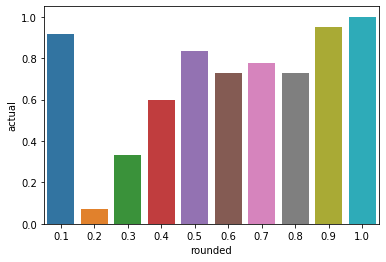

In [329]:
import seaborn as sns


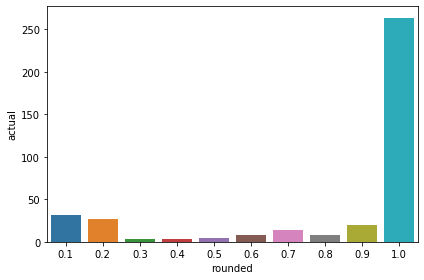

In [365]:
fig, ax1 = plt.subplots()

#ax2 = ax1.twinx()

#sns.barplot(x="rounded", y="actual", data=tot, ax = ax1, alpha = 1)
sns.barplot(x="rounded", y="actual", data=pos, ax = ax1, alpha = 1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped



In [323]:
sum_

,rounded,actual
0,0.1,32
1,0.2,27
2,0.3,3
3,0.4,3
4,0.5,5
5,0.6,8
6,0.7,14
7,0.8,8
8,0.9,20
9,1.0,264
